In [1]:
!nvidia-smi

Mon Sep 13 20:22:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:51:00.0 Off |                  N/A |
|  0%   34C    P8    14W / 250W |    803MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:CB:00.0 Off |                  N/A |
| 36%   62C    P0    82W / 250W |     12MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [19]:
import numpy as np 
import pandas as pd 
import json 

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint
import textwrap
from transformers import AdamW, T5ForConditionalGeneration, T5Tokenizer, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from tqdm.notebook import tqdm

In [20]:
device = torch.device("cuda:1")

# Stanford Question Answering Dataset
SQuAD is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text.

SQuAD2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.

In [11]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.json_normalize(file , record_path )
    m = pd.json_normalize(file, record_path[:-1] )
    r = pd.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [5]:
input_file_path = 'train-v2.0.json'
record_path = ['data','paragraphs','qas','answers']
df = squad_json_to_dataframe_train(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...
shape of the dataframe is (130319, 6)
Done


In [6]:
df[:5]

,index,question,context,text,answer_start,c_id
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269.0,0
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207.0,0
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526.0,0
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166.0,0
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276.0,0


In [7]:
df[-5:]

,index,question,context,text,answer_start,c_id
130314,5a7e070b70df9f001a875439,Physics has broadly agreed on the definition o...,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028
130315,5a7e070b70df9f001a87543a,Who coined the term partonic matter?,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028
130316,5a7e070b70df9f001a87543b,What is another name for anti-matter?,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028
130317,5a7e070b70df9f001a87543c,Matter usually does not need to be used in con...,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028
130318,5a7e070b70df9f001a87543d,What field of study has a variety of unusual c...,"The term ""matter"" is used throughout physics i...",NaN,NaN,19028


In [8]:
train_df, val_df = train_test_split(df, test_size=0.1)
train_df.shape, val_df.shape

((117287, 6), (13032, 6))

In [9]:
MODEL_NAME= "t5-base"
BATCH_SIZE = 10
N_EPOCH= 4
SOURCE_MAX_TOKEN_LEN= 300
TARGET_MAX_TOKEN_LEN= 32

In [10]:
tokenizer= T5Tokenizer.from_pretrained(MODEL_NAME)

In [11]:
len(tokenizer)

32100

### Adding our special answer

In [12]:
NO_ANSWER = '[NO_ANSWER]'

In [13]:
special_tokens_dict = {'additional_special_tokens': [NO_ANSWER]}
len_added_tokens= tokenizer.add_special_tokens(special_tokens_dict)

## T5

The basic idea underlying T5's work is to treat every text processing problem as a “text-to-text” problem, i.e. taking text as input and producing new text as output. 

In [7]:
from IPython.display import Image
images_path = 'images/'

 A diagram of the text-to-text framework. Every task we consider—including translation, question answering, and classification—is cast as feeding our model text as input and training it to generate some target text. This allows us to use the same model, loss function, hyperparameters, etc. across our diverse set of tasks.

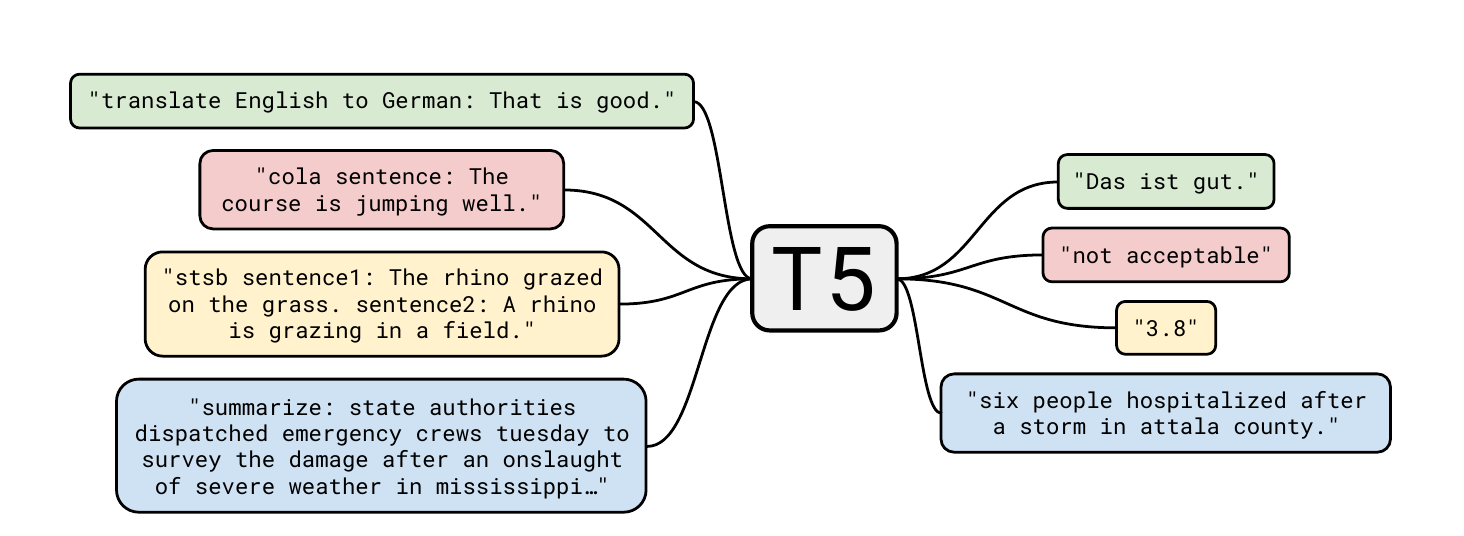

In [3]:
Image(images_path + 'text2text.png', width=800, height=700)

# how we got here

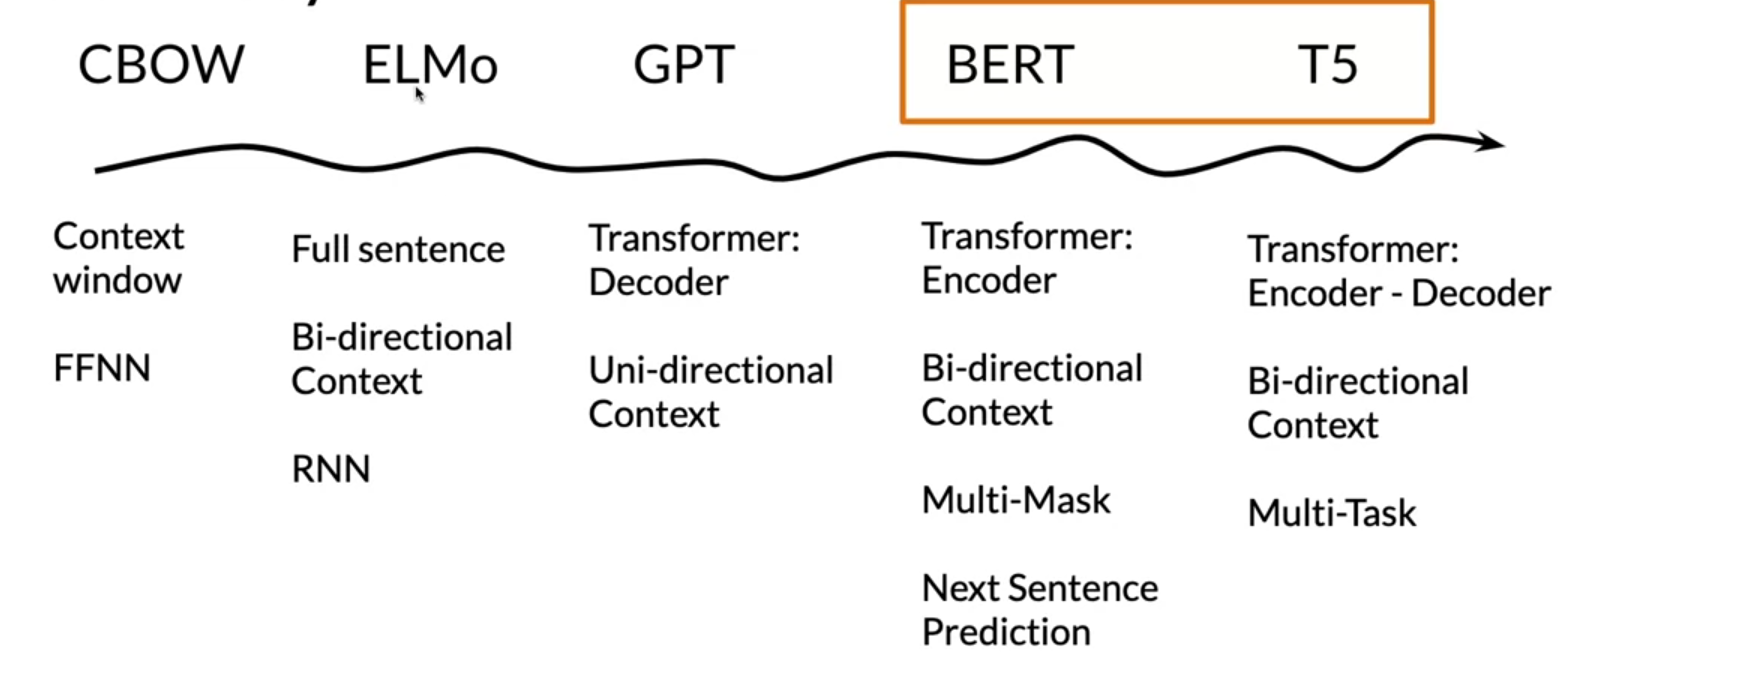

In [10]:
Image(images_path + 'timeline.png', width=900, height=700)

# Architecture

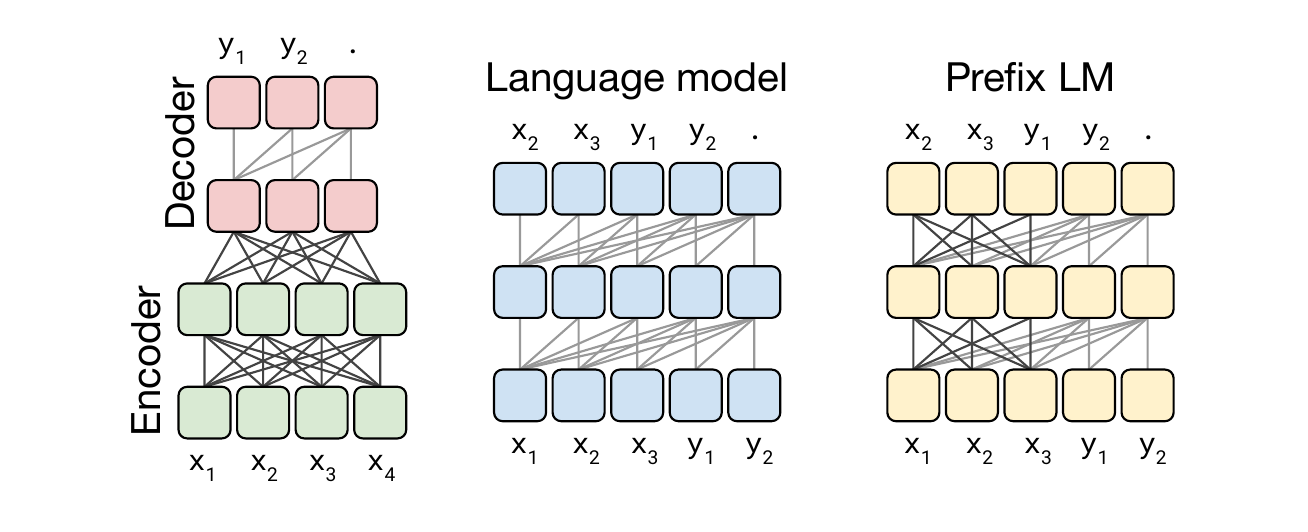

In [15]:
Image(images_path + 'LM_Types.png', width=800, height=700) 

### Attention Masks


- 1.  Fully-visible mask allows the self-attention mechanism to attend to the full input at every output timestep
- 2.  Causal mask prevents the ith output element from depending on any input elements from “the future”.
- 3.  Causal masking with a prefix allows the self-attention mechanism to use fully-visible masking on a portion of the input sequence.


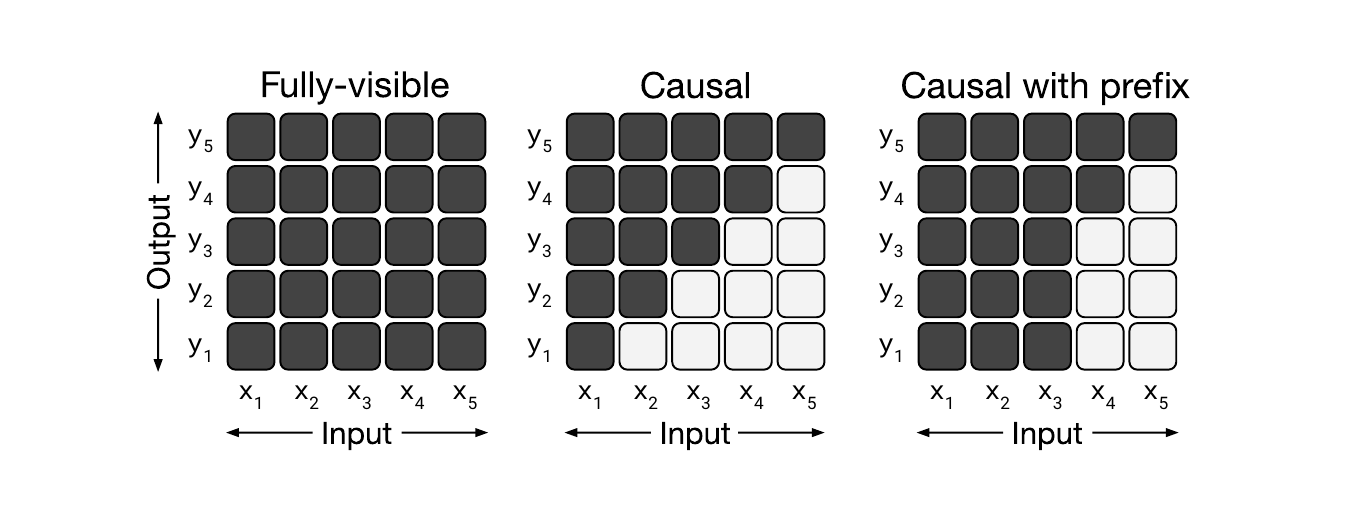

In [27]:
Image(images_path + 'attention.png', width=800, height=700)

### Casual With Prefix
In the English to German translation for example:
- Fully-visible masking would be applied to the prefix “translate English to German: That is good. target:” 
- Causal masking would be used during training for predicting the target “Das ist gut.” 

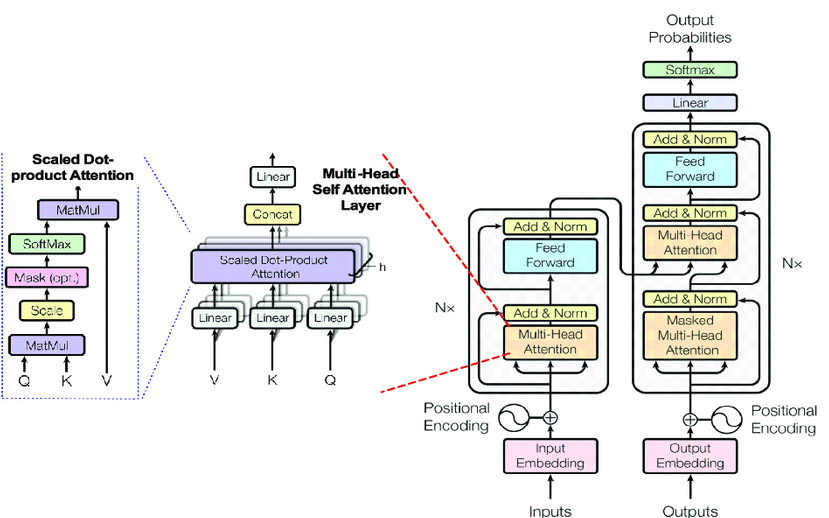

In [6]:
Image(images_path + 'transformer.png', width=800, height=700)

### Data Trip:
- An input sequence of tokens is mapped to a sequence of embeddings, 
- The embeddings then passed into the encoder. 
- The **encoder** consists of a stack of “blocks”, each of which comprises two subcomponents: 
    - Self-attention layer
    - Small feed-forward network. 
    - Layer normalization is applied to the input of each subcomponent. Simplified version of layer normalization is used where the activations are only rescaled and no additive bias is applied. After layer normalization, a residual skip connection adds each subcomponent’s input to its output.
    - Dropout is applied within the feed-forward network, on the skip connection, on the attention weights, and at the input and output of the entire stack.
    
    
- The **decoder** is similar in structure to the encoder except that:
    - It includes a standard attention mechanism after each self-attention layer that attends to the output of the encoder. The self-attention mechanism in the decoder also uses a form of **autoregressive** or causal self-attention, which only allows the model to attend to past outputs.
    - The output of the final decoder block is fed into a dense layer with a softmax output, whose weights are shared with the input embedding matrix.


### Model Structures

- An encoder-decoder model with L layers in the encoder and L layers in the decoder. This model has 2P parameters and a computation cost of M FLOPs.
- An equivalent model, but with parameters shared across the encoder and decoder, resulting in P parameters and an M FLOP computational cost.
- An encoder-decoder model with L/2 layers each in the encoder and decoder, giving P parameters and an M/2-FLOP cost.
- A decoder-only language model with L layers and P parameters and a resulting computational cost of M FLOPs.
- A decoder-only prefix LM with the same architecture (and thus the same number of parameters and computational cost), but with fully-visible self-attention over the input.


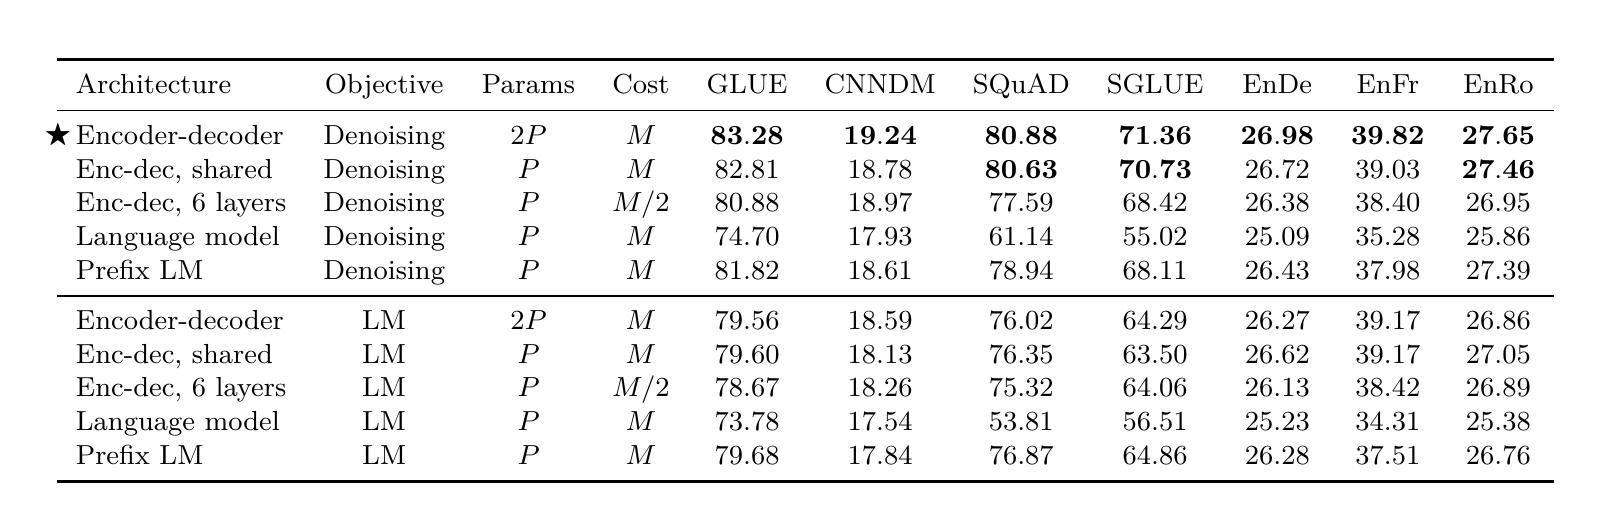

In [18]:
Image(images_path + 'performances2.png', width=1000, height=850)

### Unsupervised Objectives

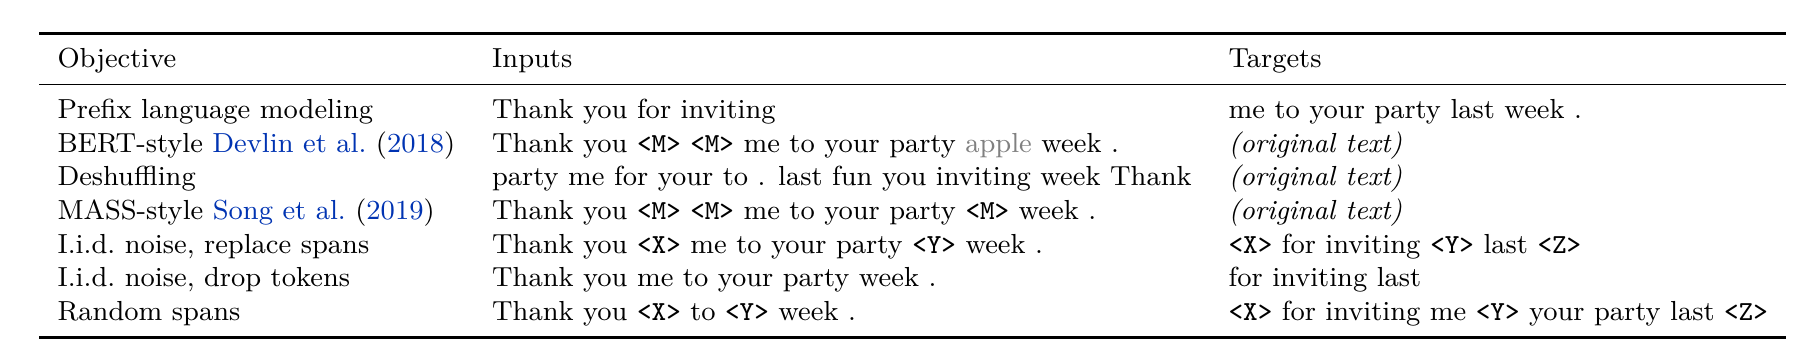

In [24]:
Image(images_path + 'Objectives examples.png', width=1000, height=800) 

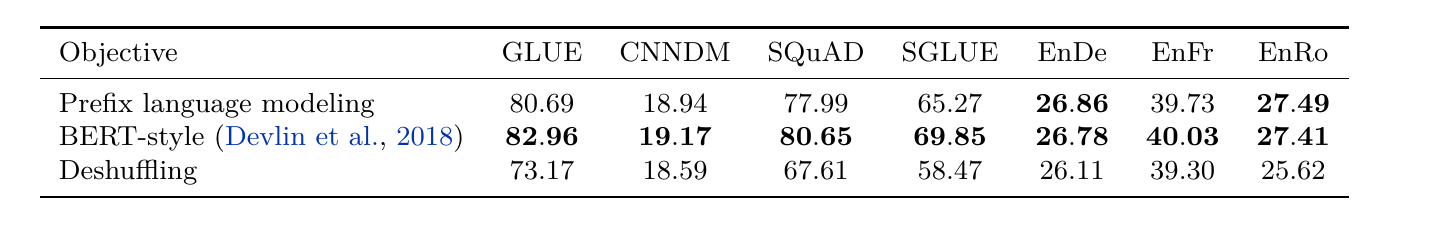

In [25]:
Image(images_path + 'performances1.png', width=1000, height=800) 

# Simplifying the BERT Objective

- **BERT-style**: replaces 15% of the tokens in the input with a mask token and the model is trained to reconstruct the original uncorrupted sequence. *doesn’t include the random token swapping step*.
- **MASS-style** : [Paper](https://arxiv.org/pdf/1905.02450.pdf)
- **Replace corrupted spans**: replaces the entirety of each consecutive span of corrupted tokens with a unique mask token. Then, the target sequence becomes the concatenation of the “corrupted” spans, each prefixed by the mask token used to replace it in the input.
- **Drop corrupted tokens** : drop the corrupted tokens from the input sequence completely and task the model with reconstructing the dropped tokens in order.

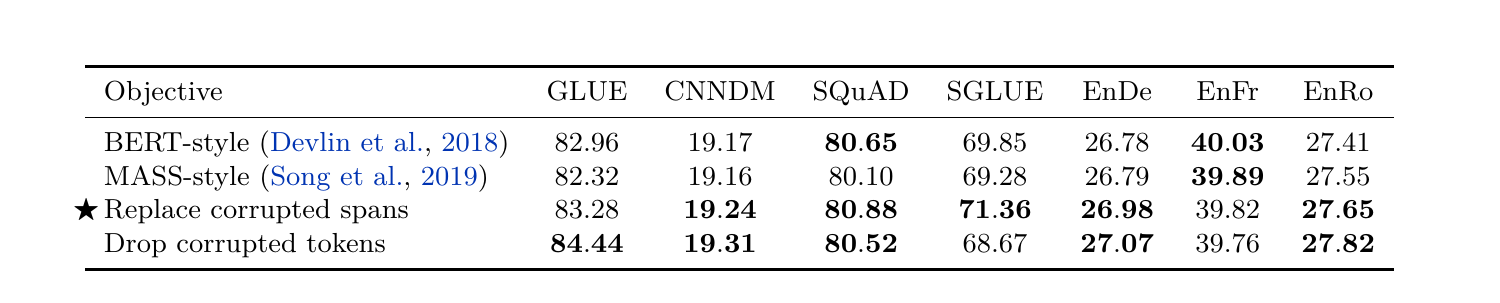

In [21]:
Image(images_path + 'performances3.png', width=1000, height=800) 

### Varying the Corruption Rate

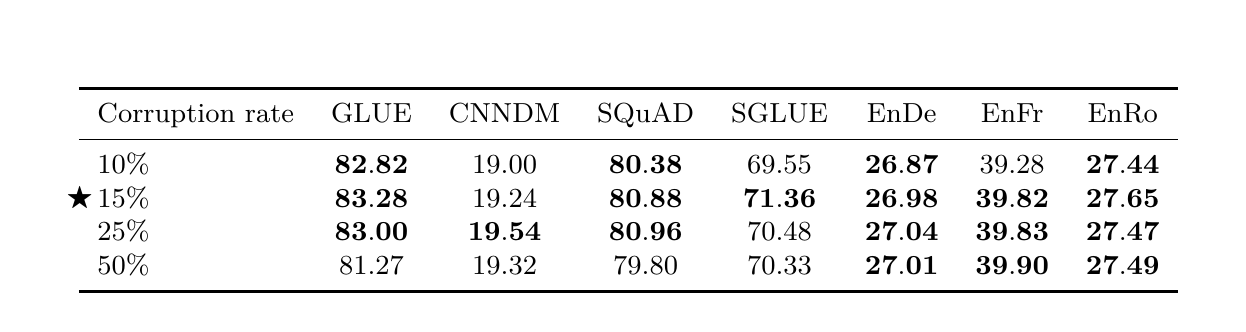

In [20]:
Image(images_path + 'performances4.png', width=1000, height=800) 

# Data Set

T5 uses common crawl web extracted text. The authors apply some pretty simple heuristic filtering. 
- Removes any lines that didn’t end in a terminal punctuation mark. 
- Discarded any page with fewer than 5 sentences and only retained lines that contained at least 3 words.
- Removed any page that contained any word on the “List of Dirty, Naughty, Obscene or Otherwise Bad Words”
- Removes line with the word javascript and any pages that had a curly bracket (since it often appears in code). 
- They deduplicates the dataset by taking a sliding window of 3 sentence chunks and discarded all but one of any chunk occurring more than once in the data set.
- Removed any page where the phrase “lorem ipsum” appeared.
- Filter out any pages that were not classified as English with a probability of at least 0.99

# Training

Inspired by BERT’s “masked language modeling” objective and the “word dropout” regularization technique, we design an objective that:
- Randomly samples and then drops out 15% of tokens in the input sequence. 
- All consecutive spans of dropped-out tokens are replaced by a single sentinel token. 
- Each sentinel token is assigned a token ID that is unique to the sequence. 
- The sentinel IDs are special tokens which are added to our vocabulary and do not correspond to any wordpiece. 
- The target then corresponds to all of the dropped-out spans of tokens, delimited by the same sentinel tokens used in the input sequence plus a final sentinel token to mark the end of the target sequence. 
- Our choices to mask consecutive spans of tokens and **only predict dropped-out tokens** were made to reduce the computational cost of pre-training. 

In [14]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)
model.resize_token_embeddings(len(tokenizer))
optimizer = AdamW(model.parameters(), lr=0.0001)

Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
class SQuADDataset(Dataset):
    def __init__(self, data: pd.DataFrame, 
                 tokenizer: T5Tokenizer, 
                 source_max_token_len: int = 256, 
                 target_max_token_len= 32):
        
        self.tokenizer= tokenizer
        self.data= data
        self.source_max_token_len= source_max_token_len
        self.target_max_token_len= target_max_token_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        source_encoding = self.tokenizer(
            data_row['question'],
            data_row['context'],
            max_length=self.source_max_token_len,
            padding= "max_length",
            truncation= "only_second",
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors= "pt"
        )
        answer_text = NO_ANSWER if pd.isnull(data_row['text']) else data_row['text']
        target_encoding = self.tokenizer(
                answer_text,
                max_length=self.target_max_token_len,
                padding= "max_length",
                truncation= True,
                return_attention_mask=True,
                add_special_tokens=True,
                return_tensors= "pt"
            )
        
        labels = target_encoding["input_ids"]
        labels[labels==0] = -100
        
        return (data_row["question"],
                data_row['context'],
                answer_text,
                source_encoding["input_ids"].flatten(),
                source_encoding["attention_mask"].flatten(),
                labels.flatten())
        

In [16]:
train_dataset= SQuADDataset(data= train_df, 
                             tokenizer= tokenizer,
                             source_max_token_len= SOURCE_MAX_TOKEN_LEN,
                             target_max_token_len= TARGET_MAX_TOKEN_LEN)

val_dataset= SQuADDataset(data= val_df, 
                             tokenizer= tokenizer,
                             source_max_token_len= SOURCE_MAX_TOKEN_LEN,
                             target_max_token_len= TARGET_MAX_TOKEN_LEN)

In [17]:
train_loader= DataLoader(train_dataset,
                         batch_size= BATCH_SIZE,
                         shuffle= True,
                         num_workers=4)

val_loader= DataLoader(val_dataset,
                         batch_size= BATCH_SIZE,
                         shuffle= True,
                         num_workers=4)

In [18]:
min_val_loss= float('inf')
for epoch in range(N_EPOCH):    
    model.train()
    train_epoch_loss = 0
    for question, context, answer_text, input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch}: Traingin"):
        input_ids= input_ids.to(device)
        attention_mask= attention_mask.to(device)
        labels= labels.to(device)
        optimizer.zero_grad()

        output = model(input_ids= input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits  =output.loss, output.logits
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.detach().item()
    
    train_epoch_loss /= len(train_loader)
    
    val_epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for question, context, answer_text, input_ids, attention_mask, labels in tqdm(val_loader, desc=f'Epoch {epoch}: Validation'):
            input_ids= input_ids.to(device)
            attention_mask= attention_mask.to(device)
            labels= labels.to(device)
            optimizer.zero_grad()

            output = model(input_ids= input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits  =output.loss, output.logits

            val_epoch_loss += loss.detach().item()
    val_epoch_loss /= len(val_loader)
    
    print(f'Epoch: {epoch}, Train Loss: {train_epoch_loss}, Validation Loss: {val_epoch_loss}')
    if min_val_loss > val_epoch_loss:
        print(f"Update Model at Epoch :{epoch}")
        torch.save({'state_dict': model.state_dict()}, 'model.tar')
        min_val_loss = val_epoch_loss

Epoch 0: Traingin:   0%|          | 0/11729 [00:00<?, ?it/s]

Epoch 0: Validation:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.6466876193944557, Validation Loss: 0.3474362410288561
Update Model at Epoch :0


Epoch 1: Traingin:   0%|          | 0/11729 [00:00<?, ?it/s]

Epoch 1: Validation:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.3533726451985658, Validation Loss: 0.3349837488873342
Update Model at Epoch :1


Epoch 2: Traingin:   0%|          | 0/11729 [00:00<?, ?it/s]

Epoch 2: Validation:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.2617824972867321, Validation Loss: 0.339365730365664


Epoch 3: Traingin:   0%|          | 0/11729 [00:00<?, ?it/s]

Epoch 3: Validation:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.2047569936936835, Validation Loss: 0.3534717353459368


## Evaluate Our model

In [21]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))
checkpoint = torch.load('model.tar')
model.load_state_dict(checkpoint['state_dict'])
model= model.to(device)

Some weights of the model checkpoint at t5-base were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
# these functions are heavily influenced by the HF squad_metrics.py script
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [23]:
def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

In [24]:
def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [60]:
eval_loader= DataLoader(val_dataset,
                         batch_size= 1,
                         shuffle= False,
                         num_workers=4)

In [67]:
def generate_answer(question):
    source_encoding = tokenizer(
            question['question'],
            question['context'],
            max_length=369,
            padding= "max_length",
            truncation= "only_second",
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors= "pt"
        ).to(device)
    
    generated_ids = model.generate(
        input_ids=source_encoding['input_ids'],
        attention_mask= source_encoding['attention_mask'],
        num_beams= 1,
        max_length=80,
        length_penalty=1.0,
        early_stopping=True,
        use_cache= True
    )
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=False, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]
    predicted_answer= "".join(preds)
    predicted_answer= predicted_answer.replace('</s>', '')
    predicted_answer= predicted_answer.replace('<pad>', '')
    return predicted_answer

In [65]:
EM= 0
F1= 0
model.eval()
with torch.no_grad():
    for question, context, answer_text, input_ids, attention_mask, labels in tqdm(eval_loader, desc=f'Validation'):
        sample = {"context": context[0], "question": question[0]}
        predicted_answer= generate_answer(sample)
        
        EM += compute_exact_match(answer_text[0], predicted_answer)
        F1 += compute_f1(answer_text[0], predicted_answer)
    EM /= len(eval_loader)
    F1 /= len(eval_loader)
    print(f"F1: {F1}, EM: {EM}")

Validation:   0%|          | 0/13032 [00:00<?, ?it/s]

F1: 0.8058683708079691, EM: 0.7328882750153468


In [68]:
sample = val_df.iloc[890]
print(f"Context is: {sample['context']}"
      f"\nQuestion is: {sample['question']}"
      f"\nActual answer: {sample['text']}"
      f"\nPredected answer: {generate_answer(sample)}")

Context is: Copper is an essential trace element in plants and animals, but not some microorganisms. The human body contains copper at a level of about 1.4 to 2.1 mg per kg of body mass. Stated differently, the RDA for copper in normal healthy adults is quoted as 0.97 mg/day and as 3.0 mg/day. Copper is absorbed in the gut, then transported to the liver bound to albumin. After processing in the liver, copper is distributed to other tissues in a second phase. Copper transport here involves the protein ceruloplasmin, which carries the majority of copper in blood. Ceruloplasmin also carries copper that is excreted in milk, and is particularly well-absorbed as a copper source. Copper in the body normally undergoes enterohepatic circulation (about 5 mg a day, vs. about 1 mg per day absorbed in the diet and excreted from the body), and the body is able to excrete some excess copper, if needed, via bile, which carries some copper out of the liver that is not then reabsorbed by the intestine.


In [69]:
sample = val_df.iloc[600]
print(f"Context is: {sample['context']}"
      f"\nQuestion is: {sample['question']}"
      f"\nActual answer: {sample['text']}"
      f"\nPredected answer: {generate_answer(sample)}")


Context is: The second Digimon series is direct continuation of the first one, and began airing on April 2, 2000. Three years later, with most of the original DigiDestined now in high school at age fourteen, the Digital World was supposedly secure and peaceful. However, a new evil has appeared in the form of the Digimon Emperor (Digimon Kaiser) who as opposed to previous enemies is a human just like the DigiDestined. The Digimon Emperor has been enslaving Digimon with Dark Rings and Control Spires and has somehow made regular Digivolution impossible. However, five set Digi-Eggs with engraved emblems had been appointed to three new DigiDestined along with T.K. and Kari, two of the DigiDestined from the previous series. This new evolutionary process, dubbed Armor Digivolution helps the new DigiDestined to defeat evil lurking in the Digital World. Eventually, the DigiDestined defeat the Digimon Emperor, more commonly known as Ken Ichijouji on Earth, only with the great sacrifice of Ken's 

In [70]:
sample = val_df.iloc[8]
print(f"Context is: {sample['context']}"
      f"\nQuestion is: {sample['question']}"
      f"\nActual answer: {sample['text']}"
      f"\nPredected answer: {generate_answer(sample)}")


Context is: Twilight Princess received the awards for Best Artistic Design, Best Original Score, and Best Use of Sound from IGN for its GameCube version. Both IGN and Nintendo Power gave Twilight Princess the awards for Best Graphics and Best Story. Twilight Princess received Game of the Year awards from GameTrailers, 1UP.com, Electronic Gaming Monthly, Game Informer, Games Radar, GameSpy, Spacey Awards, X-Play and Nintendo Power. It was also given awards for Best Adventure Game from the Game Critics Awards, X-Play, IGN, GameTrailers, 1UP.com, and Nintendo Power. The game was considered the Best Console Game by the Game Critics Awards and GameSpy. The game placed 16th in Official Nintendo Magazine's list of the 100 Greatest Nintendo Games of All Time. IGN ranked the game as the 4th-best Wii game. Nintendo Power ranked the game as the third-best game to be released on a Nintendo system in the 2000s decade.
Question is: What 2 critics gave Game Radar awards for Best Graphics and Best Sto

In [73]:
sample = val_df.iloc[456]
print(f"Context is: {sample['context']}"
      f"\nQuestion is: {sample['question']}"
      f"\nActual answer: {sample['text']}"
      f"\nPredected answer: {generate_answer(sample)}")

Context is: In a 2009 case, Netbula, LLC v. Chordiant Software Inc., defendant Chordiant filed a motion to compel Netbula to disable the robots.txt file on its web site that was causing the Wayback Machine to retroactively remove access to previous versions of pages it had archived from Nebula's site, pages that Chordiant believed would support its case.
Question is: What did Chordiant request that the court deactivate on Netbula's website?
Actual answer: the robots.txt file
Predected answer:  robots.txt


In [74]:
sample = val_df.iloc[86]
print(f"Context is: {sample['context']}"
      f"\nQuestion is: {sample['question']}"
      f"\nActual answer: {sample['text']}"
      f"\nPredected answer: {generate_answer(sample)}")

Context is: In 2005, the constitution was put into effect. There is still much debate in the country about the constitutional reforms. From the early seventies, there was active resistance to the royal hegemony. Despite complaints from progressive formations, support for the monarchy and the current political system remains strong among the majority of the population.[citation needed] Submissions were made by citizens around the country to commissions, including the constitutional draft committee, indicating that they would prefer to maintain the current situation.
Question is: When did people begin to disputre royal hegenomy in Swaziland?
Actual answer: the early seventies
Predected answer:  early seventies


In [75]:
sample = val_df.iloc[8979]
print(f"Context is: {sample['context']}"
      f"\nQuestion is: {sample['question']}"
      f"\nActual answer: {sample['text']}"
      f"\nPredected answer: {generate_answer(sample)}")

Context is: Catholic missionary Father A. Erdland, from the Sacred Heart Jesu Society based in Hiltrup, Germany, lived on Jaluit from around 1904 to 1914. He was very interested in the islands and conducted considerable research on the Marshallese culture and language. He published a 376-page monograph on the islands in 1914. Father H. Linckens, another missionary from the Sacred Heart of Jesu Society visited the Marshall Islands in 1904 and 1911 for several weeks. He published a small work in 1912 about the Catholic mission activities and the people of the Marshall Islands.
Question is: In what year was Father Linckens' last visit to the Marshalls?
Actual answer: 1911
Predected answer:  1911
